In [1]:
import pandas as pd
import numpy as np
import os
import time
from astropy.cosmology import Planck13
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import disperse

from sklearn.neighbors import KDTree

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
cosmo = Planck13
H0 = cosmo.H0.value
Om = cosmo.Om0
Ol = 0.69288
Ok = 0.0
print(f'H0 = {cosmo.H0.value}')
print(f'Om = {cosmo.Om0}')
print(f'Ol = {0.69288}')

H0 = 67.77
Om = 0.30712
Ol = 0.69288


In [3]:
np.random.seed(0)

In [4]:
gal_RA_int = (140, 260)
gal_DEC_int = (-10, 30)
gal_Z_int = (0, 1.0)

In [5]:
galaxies = pd.read_csv('SDSS/SDSS_DR16.csv')
galaxies = galaxies[galaxies['class'] == 'GALAXY']
galaxies = galaxies[(gal_RA_int[0] <= galaxies['ra']) & (galaxies['ra'] <= gal_RA_int[1])]
galaxies = galaxies[(gal_DEC_int[0] <= galaxies['dec']) & (galaxies['dec'] <= gal_DEC_int[1])]
galaxies = galaxies[(gal_Z_int[0] < galaxies['z']) & (galaxies['z'] <= gal_Z_int[1])]
galaxies = galaxies[['ra', 'dec', 'z']]
galaxies.columns = ['RA', 'DEC', 'Z']
galaxies.drop_duplicates(subset=['RA', 'DEC', 'Z'])
galaxies.reset_index(drop=True, inplace=True)

In [6]:
galaxies.to_csv('ACT_galaxies.csv', index=False)

In [7]:
util_DPS = disperse.Disperse3D(
    galaxies, '_disperse_03/bin/',
    H0, Om, Ol, Ok,
    clusters=None
)

In [8]:
cl_RA_int = (160, 240)
cl_DEC_int = (0, 20)
cl_Z_int = (0, 1.0)

In [9]:
dat = Table.read('DR5_cluster-catalog_v1.1.fits', format='fits')
true_clusters = dat[['RADeg', 'decDeg', 'redshift', 'redshiftType', 'M500c']].to_pandas()
true_clusters = true_clusters[true_clusters['redshiftType'] == b'spec']
true_clusters = true_clusters[['RADeg', 'decDeg', 'redshift', 'M500c']]
true_clusters.columns = ['RA', 'DEC', 'Z', 'M']
true_clusters = true_clusters[(cl_RA_int[0] <= true_clusters['RA']) & (true_clusters['RA'] <= cl_RA_int[1])]
true_clusters = true_clusters[(cl_DEC_int[0] <= true_clusters['DEC']) & (true_clusters['DEC'] <= cl_DEC_int[1])]
true_clusters = true_clusters[(cl_Z_int[0] < true_clusters['Z']) & (true_clusters['Z'] <= cl_Z_int[1])]
true_clusters = true_clusters[['RA', 'DEC', 'Z', 'M']]
true_clusters.columns = ['RA', 'DEC', 'Z', 'M']
true_clusters.drop_duplicates(subset=['RA', 'DEC', 'Z', 'M'])
true_clusters = true_clusters.sort_values(by=['Z'])
true_clusters.reset_index(drop=True, inplace=True)
true_clusters['R'] = [0] * true_clusters.shape[0]
true_clusters['type'] = [1] * true_clusters.shape[0]
CX, CY, CZ = util_DPS.sph2cart(true_clusters['RA'], true_clusters['DEC'], true_clusters['Z'])
true_clusters['CX'] = CX
true_clusters['CY'] = CY
true_clusters['CZ'] = CZ
true_clusters['ID'] = list(range(true_clusters.shape[0]))
true_clusters

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID
0,230.761495,8.587807,0.035200,1.676978,0,1,-96.597031,-118.277283,23.062053,0
1,230.452957,7.709549,0.044200,2.457475,0,1,-122.101803,-147.873793,25.960786,1
2,227.733561,5.744353,0.076600,11.002140,0,1,-222.703294,-245.035914,33.308899,2
3,208.253128,5.139146,0.078800,1.222567,0,1,-300.190348,-161.319215,30.649445,3
4,173.207731,14.465334,0.083200,2.935207,0,1,-346.994931,41.329156,90.147741,4
...,...,...,...,...,...,...,...,...,...,...
514,190.801637,13.213381,0.789772,1.827705,0,1,-2716.094276,-518.203135,649.226460,514
515,160.265704,10.675110,0.789868,4.328044,0,1,-2627.451148,942.538451,526.183483,515
516,199.909131,15.890405,0.796336,1.899555,0,1,-2585.211521,-936.299514,782.729567,516
517,211.772844,10.806421,0.836000,6.430338,0,1,-2479.343209,-1535.631547,556.669132,517


In [10]:
#генерация случайных скоплений
RANDOM_CL_NUM = 3000
TRUE_R = 20
TRUE_CL_NUM = true_clusters.shape[0]

RA_int = (true_clusters['RA'].min(), true_clusters['RA'].max())
DEC_int = (true_clusters['DEC'].min(), true_clusters['DEC'].max())
Z_int = (true_clusters['Z'].min(), np.quantile(true_clusters['Z'], [1])[0])

CX, CY, CZ = util_DPS.sph2cart(
    true_clusters['RA'], true_clusters['DEC'], true_clusters['Z']
)
points = [[CX[i], CY[i], CZ[i]] for i in range(true_clusters.shape[0])]
kd_tree = KDTree(points, leaf_size=2)

not_generate = RANDOM_CL_NUM
RA, DEC, Z = np.array([]), np.array([]), np.array([])
while not_generate > 0:
    print('###')
    RA_ = np.random.uniform(RA_int[0], RA_int[1], not_generate)
    DEC_ = np.random.uniform(DEC_int[0], DEC_int[1], not_generate)
    
#     Z_ = np.random.uniform(Z_int[0], Z_int[1], not_generate)
#     noise = np.random.normal(0, 0.005, not_generate)
    Z_ = np.random.choice(true_clusters['Z'], not_generate) # + noise
    
    CX, CY, CZ = util_DPS.sph2cart(RA_, DEC_, Z_)
    points = [[CX[i], CY[i], CZ[i]] for i in range(not_generate)]
    inters = kd_tree.query_radius(points, TRUE_R, count_only=True)
    RA = np.concatenate((RA, RA_[inters==0]))
    DEC = np.concatenate((DEC, DEC_[inters==0]))
    Z = np.concatenate((Z, Z_[inters==0]))
    not_generate = RANDOM_CL_NUM - len(RA)
    
M = [0] * RANDOM_CL_NUM
R = [0] * RANDOM_CL_NUM
type_ = [0] * RANDOM_CL_NUM

false_clusters = pd.DataFrame({
    'RA': RA, 'DEC': DEC, 'Z': Z, 'M': M, 'R': R, 'type': type_
})
false_clusters = false_clusters.sort_values(by=['Z'])
false_clusters.reset_index(drop=True, inplace=True)
CX, CY, CZ = util_DPS.sph2cart(false_clusters['RA'], false_clusters['DEC'], false_clusters['Z'])
false_clusters['CX'] = CX
false_clusters['CY'] = CY
false_clusters['CZ'] = CZ
false_clusters['ID'] = true_clusters.shape[0] + np.array(range(false_clusters.shape[0]))
false_clusters

###
###
###


,RA,DEC,Z,M,R,type,CX,CY,CZ,ID
0,203.937346,8.307028,0.0352,0,0,0,-139.677456,-62.005483,22.313419,519
1,190.992530,0.223012,0.0352,0,0,0,-151.607249,-29.448953,0.601131,520
2,201.572820,2.300791,0.0352,0,0,0,-143.507797,-56.740023,6.200170,521
3,179.846096,13.701062,0.0352,0,0,0,-150.046861,0.403047,36.580560,522
4,208.626549,6.281232,0.0352,0,0,0,-134.749451,-73.548804,16.897311,523
...,...,...,...,...,...,...,...,...,...,...
2995,195.258283,9.471381,0.9750,0,0,0,-3174.029164,-865.832664,548.868644,3514
2996,228.743762,0.269355,0.9750,0,0,0,-2199.479254,-2507.474677,15.680420,3515
2997,209.909774,18.112089,0.9750,0,0,0,-2747.967683,-1580.775317,1036.921951,3516
2998,211.766151,11.274241,0.9750,0,0,0,-2781.108471,-1722.086506,652.102646,3517


In [11]:
clusters = pd.concat((true_clusters, false_clusters), axis=0)
clusters.reset_index(drop=True, inplace=True)
clusters

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID
0,230.761495,8.587807,0.0352,1.676978,0,1,-96.597031,-118.277283,23.062053,0
1,230.452957,7.709549,0.0442,2.457475,0,1,-122.101803,-147.873793,25.960786,1
2,227.733561,5.744353,0.0766,11.002140,0,1,-222.703294,-245.035914,33.308899,2
3,208.253128,5.139146,0.0788,1.222567,0,1,-300.190348,-161.319215,30.649445,3
4,173.207731,14.465334,0.0832,2.935207,0,1,-346.994931,41.329156,90.147741,4
...,...,...,...,...,...,...,...,...,...,...
3514,195.258283,9.471381,0.9750,0.000000,0,0,-3174.029164,-865.832664,548.868644,3514
3515,228.743762,0.269355,0.9750,0.000000,0,0,-2199.479254,-2507.474677,15.680420,3515
3516,209.909774,18.112089,0.9750,0.000000,0,0,-2747.967683,-1580.775317,1036.921951,3516
3517,211.766151,11.274241,0.9750,0.000000,0,0,-2781.108471,-1722.086506,652.102646,3517


In [12]:
sigmas = [round(i, 1) for i in np.arange(0.2, 14.2, 0.2)]

In [13]:
f_name = 'ACT_05_dists_without_noise.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        dists = np.load(f)
else:
    dists = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(clusters['R'], clusters)
        dists.append(np.array(cl_dists)[None,:])
    dists = np.concatenate(dists, axis=0)
    dists = dists.T
    with open(f_name, 'wb') as f:
        np.save(f, dists)
    
print(dists.shape)

(3519, 70)


In [14]:
clusters_to_save = clusters.copy()
for i, sigma in enumerate(sigmas):
    clusters_to_save[f'd_{sigma}'] = dists[:, i]
    
clusters_to_save.to_csv('ACT_clusters.csv', index=False)

In [15]:
z = [round(i, 4) for i in np.arange(0.002, 1.0, 0.002)]

ID, RA, DEC, Z, Z_true, M, R, TYPE = [], [], [], [], [], [], [], []
for i in range(clusters.shape[0]):
    row = clusters.iloc[i]
    ID = ID + [int(row['ID'])] * len(z)
    RA = RA + [row['RA']] * len(z)
    DEC = DEC + [row['DEC']] * len(z)
    Z = Z + z.copy()
    Z_true = Z_true + [row['Z']] * len(z)
    TYPE = TYPE + [int(row['type'])] * len(z)
    M = M + [row['M']] * len(z)
    R = R + [row['R']] * len(z)
CX, CY, CZ = util_DPS.sph2cart(RA, DEC, Z)
clusters_ext = pd.DataFrame({
    'ID': ID, 'RA': RA, 'DEC': DEC, 'Z': Z,
    'CX': CX, 'CY': CY, 'CZ': CZ,
    'Z_true': Z_true, 'M': M, 'R': R, 'type': TYPE
})

clusters_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R,type
0,0,230.761495,8.587807,0.002,-5.531095,-6.772495,1.320521,0.0352,1.676978,0.0,1
1,0,230.761495,8.587807,0.004,-11.057085,-13.538739,2.639823,0.0352,1.676978,0.0,1
2,0,230.761495,8.587807,0.006,-16.577964,-20.298725,3.957905,0.0352,1.676978,0.0,1
3,0,230.761495,8.587807,0.008,-22.093726,-27.052446,5.274765,0.0352,1.676978,0.0,1
4,0,230.761495,8.587807,0.010,-27.604365,-33.799893,6.590403,0.0352,1.676978,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1755976,3518,189.207861,10.112176,0.990,-3278.055129,-531.390651,592.261022,0.9750,0.000000,0.0,0
1755977,3518,189.207861,10.112176,0.992,-3282.925090,-532.180099,593.140900,0.9750,0.000000,0.0,0
1755978,3518,189.207861,10.112176,0.994,-3287.789349,-532.968621,594.019748,0.9750,0.000000,0.0,0
1755979,3518,189.207861,10.112176,0.996,-3292.647914,-533.756221,594.897567,0.9750,0.000000,0.0,0


In [16]:
f_name = 'ACT_05_dists_ext_without_noise.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        dists_ext = np.load(f)
else:
    dists_ext = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(clusters_ext['R'], clusters_ext)
        dists_ext.append(np.array(cl_dists)[None,:])
    dists_ext = np.concatenate(dists_ext, axis=0)
    dists_ext = dists_ext.T
    with open(f_name, 'wb') as f:
        np.save(f, dists_ext)

# dists_ext = np.zeros((clusters_ext.shape[0], len(sigmas)))
print(dists_ext.shape)

(1755981, 70)


In [17]:
clusters_ext_to_save = clusters_ext.copy()
for i, sigma in enumerate(sigmas):
    clusters_ext_to_save[f'd_{sigma}'] = dists_ext[:, i]
    
# clusters_ext_to_save.to_csv('ACT_clusters_ext.csv', index=False)

In [18]:
true_m_mask = true_clusters['M'] > 0
print(true_m_mask.sum())
false_m_mask = np.array([False] * false_clusters.shape[0])
false_m_mask[::] = True
m_mask = np.concatenate((true_m_mask, false_m_mask))
z_mask = clusters['Z'] < 1.1

full_mask = m_mask * z_mask

clusters_f = clusters.loc[full_mask].copy()

clusters_f[clusters_f['type'] == 1].shape

519


/home/svasilyev/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


(519, 10)

In [19]:
TEST_RATIO = 0.1
select_step = int(1.01 // TEST_RATIO)

mask = np.array([True] * clusters_f.shape[0])
mask[::select_step] = False

train_clusters = clusters_f.loc[mask].copy()
train_clusters.reset_index(drop=True, inplace=True)
test_clusters = clusters_f.loc[~mask].copy()
test_clusters.reset_index(drop=True, inplace=True)

In [20]:
train_clusters

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID
0,230.452957,7.709549,0.0442,2.457475,0,1,-122.101803,-147.873793,25.960786,1
1,227.733561,5.744353,0.0766,11.002140,0,1,-222.703294,-245.035914,33.308899,2
2,208.253128,5.139146,0.0788,1.222567,0,1,-300.190348,-161.319215,30.649445,3
3,173.207731,14.465334,0.0832,2.935207,0,1,-346.994931,41.329156,90.147741,4
4,163.466549,16.844133,0.0854,2.420530,0,1,-339.698430,100.839024,107.282298,5
...,...,...,...,...,...,...,...,...,...,...
3162,195.258283,9.471381,0.9750,0.000000,0,0,-3174.029164,-865.832664,548.868644,3514
3163,228.743762,0.269355,0.9750,0.000000,0,0,-2199.479254,-2507.474677,15.680420,3515
3164,209.909774,18.112089,0.9750,0.000000,0,0,-2747.967683,-1580.775317,1036.921951,3516
3165,211.766151,11.274241,0.9750,0.000000,0,0,-2781.108471,-1722.086506,652.102646,3517


In [21]:
test_clusters

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID
0,230.761495,8.587807,0.035200,1.676978,0,1,-96.597031,-118.277283,23.062053,0
1,235.775108,5.770824,0.105011,1.503079,0,1,-253.544682,-372.731247,45.557881,10
2,217.958949,13.531505,0.159770,1.672366,0,1,-521.321295,-406.699659,159.123752,20
3,228.275559,6.190439,0.174354,1.404034,0,1,-489.261405,-548.663568,79.735996,30
4,221.662409,17.849673,0.200000,2.159093,0,1,-599.264179,-533.220052,258.308824,40
...,...,...,...,...,...,...,...,...,...,...
347,181.882378,11.620156,0.771080,0.000000,0,0,-2728.597445,-89.676766,561.403984,3470
348,195.646611,12.491641,0.771504,0.000000,0,0,-2621.515633,-734.239750,603.124456,3480
349,178.613334,4.691696,0.789300,0.000000,0,0,-2828.608017,68.471039,232.209216,3490
350,221.548380,10.719346,0.789868,0.000000,0,0,-2088.763002,-1851.128009,528.338472,3500


In [22]:
train_mask_ext = clusters_ext['ID'].isin(train_clusters['ID'])
train_clusters_ext = clusters_ext[train_mask_ext].copy()
train_clusters_ext.reset_index(drop=True, inplace=True)
train_clusters_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R,type
0,1,230.452957,7.709549,0.002,-5.579718,-6.757427,1.186337,0.0442,2.457475,0.0,1
1,1,230.452957,7.709549,0.004,-11.154286,-13.508618,2.371579,0.0442,2.457475,0.0,1
2,1,230.452957,7.709549,0.006,-16.723699,-20.253565,3.555724,0.0442,2.457475,0.0,1
3,1,230.452957,7.709549,0.008,-22.287949,-26.992260,4.738773,0.0442,2.457475,0.0,1
4,1,230.452957,7.709549,0.010,-27.847031,-33.724696,5.920722,0.0442,2.457475,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1580328,3518,189.207861,10.112176,0.990,-3278.055129,-531.390651,592.261022,0.9750,0.000000,0.0,0
1580329,3518,189.207861,10.112176,0.992,-3282.925090,-532.180099,593.140900,0.9750,0.000000,0.0,0
1580330,3518,189.207861,10.112176,0.994,-3287.789349,-532.968621,594.019748,0.9750,0.000000,0.0,0
1580331,3518,189.207861,10.112176,0.996,-3292.647914,-533.756221,594.897567,0.9750,0.000000,0.0,0


In [23]:
test_mask_ext = clusters_ext['ID'].isin(test_clusters['ID'])
test_clusters_ext = clusters_ext[test_mask_ext].copy()
test_clusters_ext.reset_index(drop=True, inplace=True)
test_clusters_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R,type
0,0,230.761495,8.587807,0.002,-5.531095,-6.772495,1.320521,0.0352,1.676978,0.0,1
1,0,230.761495,8.587807,0.004,-11.057085,-13.538739,2.639823,0.0352,1.676978,0.0,1
2,0,230.761495,8.587807,0.006,-16.577964,-20.298725,3.957905,0.0352,1.676978,0.0,1
3,0,230.761495,8.587807,0.008,-22.093726,-27.052446,5.274765,0.0352,1.676978,0.0,1
4,0,230.761495,8.587807,0.010,-27.604365,-33.799893,6.590403,0.0352,1.676978,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
175643,3510,195.383705,1.334661,0.990,-3251.504079,-894.618651,78.570098,0.8360,0.000000,0.0,0
175644,3510,195.383705,1.334661,0.992,-3256.334596,-895.947719,78.686824,0.8360,0.000000,0.0,0
175645,3510,195.383705,1.334661,0.994,-3261.159456,-897.275231,78.803413,0.8360,0.000000,0.0,0
175646,3510,195.383705,1.334661,0.996,-3265.978668,-898.601189,78.919865,0.8360,0.000000,0.0,0


In [24]:
FOLDS_NUM = 2

train_ID, train_Y = train_clusters['ID'], train_clusters['type']

folds = {
    'norm': [],
    'ext': []
}
for i in range(FOLDS_NUM):
    test_index = list(range(i, train_clusters.shape[0], 2))
    train_index = set(range(train_clusters.shape[0])) - set(test_index)
    train_index = sorted(train_index)
    folds['norm'].append((train_index.copy(), test_index.copy()))
    
    m = train_clusters_ext['ID'].isin(train_clusters.iloc[test_index]['ID'])
    test_index_ext = train_clusters_ext.index[m]
    train_index_ext = set(range(train_clusters_ext.shape[0])) - set(test_index_ext)
    train_index_ext = sorted(train_index_ext)
    folds['ext'].append((train_index_ext.copy(), test_index_ext.copy()))

# skf = StratifiedKFold(n_splits=FOLDS_NUM)
# skf.get_n_splits(train_ID, train_Y)

In [25]:
train_feas = np.concatenate(
    (dists[train_clusters['ID'].values], train_clusters['Z'].values.reshape(-1, 1)), axis=1
)
# train_feas = dists[train_clusters['ID'].values]
train_feas.shape

(3167, 71)

In [26]:
rads = list(range(1, 31))

In [27]:
sigma_scores = np.zeros((train_clusters.shape[0], len(rads)))
for train_index, test_index in folds['norm']:
    t = []
    for i, rad in tqdm(enumerate(rads)):
        s = np.zeros(len(test_index))
        for j, sigma in enumerate(sigmas):
            s[train_feas[test_index, j] <= rad] = sigma
        t.append(s)
    t = np.array(t).T
    sigma_scores[test_index] = t
    
sigma_rocaucs = []
for i in range(len(rads)):
    sigma_rocaucs.append(roc_auc_score(train_Y, sigma_scores[:, i]))

sigma_rocaucs

30it [00:00, 155.30it/s]
30it [00:00, 167.62it/s]


[0.6097636608771513,
 0.6631457688952336,
 0.7060579744626855,
 0.7257669125228012,
 0.7549226742802759,
 0.7816416845110635,
 0.7971032595764931,
 0.8077044174795781,
 0.816630184788643,
 0.8169398842096915,
 0.8231279244983742,
 0.8208850820842255,
 0.8190669363153302,
 0.8156051233246094,
 0.8162986755492109,
 0.8109243397573161,
 0.8035050360853357,
 0.804274724403204,
 0.8000190340233166,
 0.7896542152430803,
 0.7798386073439607,
 0.7742005710206995,
 0.7689126814180347,
 0.7629562217463717,
 0.756882385597589,
 0.7474458719961933,
 0.7402077880878737,
 0.7335232770243477,
 0.7240332302323738,
 0.7181671821714648]

In [28]:
logregs = []
logreg_scores = np.zeros(train_clusters.shape[0])
logreg_rocaucs = []
for train_index, test_index in folds['norm']:
    logreg = LogisticRegression(
        random_state=0, max_iter=10000, C=0.0005
    ).fit(train_feas[train_index], train_Y[train_index])
    logregs.append(logreg)
    preds = logreg.predict_proba(train_feas[test_index])[:,1].reshape(-1)
    logreg_scores[test_index] = preds
    logreg_rocaucs.append(roc_auc_score(train_Y[test_index], preds))
    
logreg_rocaucs

[0.838173472617917, 0.8514512796057861]

In [29]:
boostings = []
boosting_scores = np.zeros(train_clusters.shape[0])
boosting_rocaucs = []
for train_index, test_index in folds['norm']:
    boosting = lgbm.LGBMClassifier(
        boosting_type='gbdt', objective='binary',
        learning_rate=0.01, n_estimators=200,
        max_depth=10, bagging_fraction=1.0,
        reg_lambda=0.2
    ).fit(train_feas[train_index], train_Y[train_index])
    boostings.append(boosting)
    preds = boosting.predict_proba(train_feas[test_index])[:,1].reshape(-1)
    boosting_scores[test_index] = preds
    boosting_rocaucs.append(roc_auc_score(train_Y[test_index], preds))
    
boosting_rocaucs

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


[0.8644112060778727, 0.8752646638054364]

In [30]:
rfs = []
rf_scores = np.zeros(train_clusters.shape[0])
rf_rocaucs = []
for train_index, test_index in folds['norm']:
    rf = RandomForestClassifier(
        max_depth=10, 
        random_state=0,
        n_estimators=500,
        max_features=None
    ).fit(train_feas[train_index], train_Y[train_index])
    rfs.append(rf)
    preds = rf.predict_proba(train_feas[test_index])[:,1].reshape(-1)
    rf_scores[test_index] = preds
    rf_rocaucs.append(roc_auc_score(train_Y[test_index], preds))
    
rf_rocaucs

[0.871650838873061, 0.8849070100143062]

In [31]:
train_feas_ext = np.concatenate(
    (dists_ext[train_mask_ext], train_clusters_ext['Z'].values.reshape(-1, 1)), axis=1
)
# train_feas_ext = dists_ext[train_mask_ext]
train_feas_ext.shape

(1580333, 71)

In [32]:
train_sigma_scores_ext = np.zeros((train_clusters_ext.shape[0], len(rads)))
train_logreg_scores_ext = np.zeros(train_clusters_ext.shape[0])
train_boosting_scores_ext = np.zeros(train_clusters_ext.shape[0])
train_rf_scores_ext = np.zeros(train_clusters_ext.shape[0])

for k, (train_index_ext, test_index_ext) in enumerate(folds['ext']):
    t = []
    for i, rad in tqdm(enumerate(rads)):
        s = np.zeros(len(test_index_ext))
        for j, sigma in enumerate(sigmas):
            s[train_feas_ext[test_index_ext, j] <= rad] = sigma
        t.append(s)
    t = np.array(t).T
    train_sigma_scores_ext[test_index_ext] = t
    
    train_logreg_scores_ext[test_index_ext] = \
        logregs[k].predict_proba(train_feas_ext[test_index_ext])[:,1].reshape(-1)
    train_boosting_scores_ext[test_index_ext] = \
        boostings[k].predict_proba(train_feas_ext[test_index_ext])[:,1].reshape(-1)
    train_rf_scores_ext[test_index_ext] = \
        rfs[k].predict_proba(train_feas_ext[test_index_ext])[:,1].reshape(-1)

30it [00:19,  1.50it/s]
30it [00:20,  1.44it/s]


In [33]:
for i, sigma in enumerate(rads):
    train_clusters_ext[f'sigma_{sigma}_score'] = train_sigma_scores_ext[:, i]
train_clusters_ext['logreg_score'] = train_logreg_scores_ext
train_clusters_ext['boosting_score'] = train_boosting_scores_ext
train_clusters_ext['rf_score'] = train_rf_scores_ext

In [34]:
train_clusters_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R,...,sigma_24_score,sigma_25_score,sigma_26_score,sigma_27_score,sigma_28_score,sigma_29_score,sigma_30_score,logreg_score,boosting_score,rf_score
0,1,230.452957,7.709549,0.002,-5.579718,-6.757427,1.186337,0.0442,2.457475,0.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,0.353348,0.282441,0.674000
1,1,230.452957,7.709549,0.004,-11.154286,-13.508618,2.371579,0.0442,2.457475,0.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,0.359751,0.819403,0.778000
2,1,230.452957,7.709549,0.006,-16.723699,-20.253565,3.555724,0.0442,2.457475,0.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,0.361164,0.828331,0.934000
3,1,230.452957,7.709549,0.008,-22.287949,-26.992260,4.738773,0.0442,2.457475,0.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,0.253329,0.063415,0.137240
4,1,230.452957,7.709549,0.010,-27.847031,-33.724696,5.920722,0.0442,2.457475,0.0,...,8.2,8.2,8.2,8.2,8.2,8.2,8.2,0.284942,0.112161,0.154709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1580328,3518,189.207861,10.112176,0.990,-3278.055129,-531.390651,592.261022,0.9750,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005901,0.073903,0.176202
1580329,3518,189.207861,10.112176,0.992,-3282.925090,-532.180099,593.140900,0.9750,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006385,0.073903,0.176202
1580330,3518,189.207861,10.112176,0.994,-3287.789349,-532.968621,594.019748,0.9750,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006620,0.073903,0.176332
1580331,3518,189.207861,10.112176,0.996,-3292.647914,-533.756221,594.897567,0.9750,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006582,0.073903,0.176332


In [35]:
p, t = [], []
for id_ in train_clusters_ext['ID'].unique():
    p.append(train_clusters_ext[(train_clusters_ext['ID'] == id_)]['rf_score'].max())
    t.append(train_clusters_ext[(train_clusters_ext['ID'] == id_)]['type'].iloc[0])
    
roc_auc_score(np.array(t).astype(int), np.array(p))

0.5758489967483544

In [36]:
test_feas_ext = np.concatenate(
    (dists_ext[test_mask_ext], test_clusters_ext['Z'].values.reshape(-1, 1)), axis=1
)
# test_feas_ext = dists_ext[test_mask_ext]
test_feas_ext.shape

(175648, 71)

In [37]:
test_sigma_scores_ext = np.zeros((test_clusters_ext.shape[0], len(rads)))
test_logreg_scores_ext = np.zeros(test_clusters_ext.shape[0])
test_boosting_scores_ext = np.zeros(test_clusters_ext.shape[0])
test_rf_scores_ext = np.zeros(test_clusters_ext.shape[0])

t = []
for i, rad in tqdm(enumerate(rads)):
    s = np.zeros(test_clusters_ext.shape[0])
    for j, sigma in enumerate(sigmas):
        s[test_feas_ext[:, j] <= rad] = sigma
    t.append(s)
t = np.array(t).T
test_sigma_scores_ext = t

for k in range(FOLDS_NUM):
    test_logreg_scores_ext += \
        logregs[k].predict_proba(test_feas_ext)[:,1].reshape(-1)
    test_boosting_scores_ext += \
        boostings[k].predict_proba(test_feas_ext)[:,1].reshape(-1)
    test_rf_scores_ext += \
        rfs[k].predict_proba(test_feas_ext)[:,1].reshape(-1)
    
test_sigma_scores_ext /= FOLDS_NUM
test_logreg_scores_ext /= FOLDS_NUM
test_boosting_scores_ext /= FOLDS_NUM
test_rf_scores_ext /= FOLDS_NUM

30it [00:03,  9.19it/s]


In [38]:
for i, sigma in enumerate(rads):
    test_clusters_ext[f'sigma_{sigma}_score'] = test_sigma_scores_ext[:, i]
test_clusters_ext['logreg_score'] = test_logreg_scores_ext
test_clusters_ext['boosting_score'] = test_boosting_scores_ext
test_clusters_ext['rf_score'] = test_rf_scores_ext

test_clusters_ext['clf_mean'] = np.mean(
    [test_logreg_scores_ext, test_boosting_scores_ext, test_rf_scores_ext],
    axis=0
)
test_clusters_ext['clf_mul'] = \
    test_logreg_scores_ext * test_boosting_scores_ext * test_rf_scores_ext

In [39]:
test_clusters_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R,...,sigma_26_score,sigma_27_score,sigma_28_score,sigma_29_score,sigma_30_score,logreg_score,boosting_score,rf_score,clf_mean,clf_mul
0,0,230.761495,8.587807,0.002,-5.531095,-6.772495,1.320521,0.0352,1.676978,0.0,...,7.0,7.0,7.0,7.0,7.0,3.664964e-01,0.581867,0.631000,0.526454,1.345621e-01
1,0,230.761495,8.587807,0.004,-11.057085,-13.538739,2.639823,0.0352,1.676978,0.0,...,7.0,7.0,7.0,7.0,7.0,3.747642e-01,0.732014,0.647000,0.584593,1.774932e-01
2,0,230.761495,8.587807,0.006,-16.577964,-20.298725,3.957905,0.0352,1.676978,0.0,...,7.0,7.0,7.0,7.0,7.0,3.581402e-01,0.801891,0.736000,0.632010,2.113714e-01
3,0,230.761495,8.587807,0.008,-22.093726,-27.052446,5.274765,0.0352,1.676978,0.0,...,7.0,7.0,7.0,7.0,7.0,2.261558e-01,0.086666,0.219783,0.177535,4.307768e-03
4,0,230.761495,8.587807,0.010,-27.604365,-33.799893,6.590403,0.0352,1.676978,0.0,...,4.1,4.1,4.1,4.1,4.1,2.806979e-01,0.187903,0.259640,0.242747,1.369444e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175643,3510,195.383705,1.334661,0.990,-3251.504079,-894.618651,78.570098,0.8360,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,2.229834e-07,0.036744,0.106605,0.047783,8.734407e-10
175644,3510,195.383705,1.334661,0.992,-3256.334596,-895.947719,78.686824,0.8360,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.774495e-07,0.037028,0.104490,0.047173,6.865549e-10
175645,3510,195.383705,1.334661,0.994,-3261.159456,-897.275231,78.803413,0.8360,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.389966e-07,0.037028,0.104468,0.047165,5.376683e-10
175646,3510,195.383705,1.334661,0.996,-3265.978668,-898.601189,78.919865,0.8360,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.072454e-07,0.037028,0.105450,0.047493,4.187473e-10


In [40]:
p, t = [], []
for id_ in test_clusters_ext['ID'].unique():
    p.append(test_clusters_ext[(test_clusters_ext['ID'] == id_)]['rf_score'].max())
    t.append(test_clusters_ext[(test_clusters_ext['ID'] == id_)]['type'].iloc[0])
    
roc_auc_score(np.array(t).astype(int), np.array(p))

0.5817307692307692

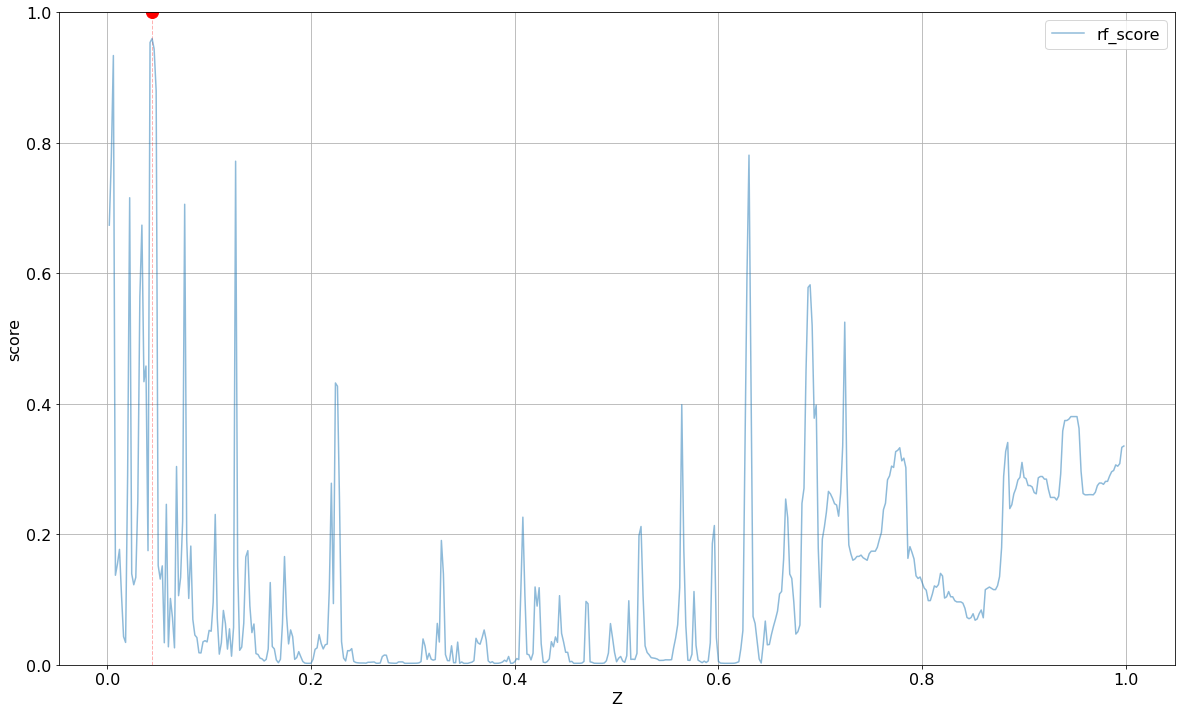

In [41]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 12))
plt.ylim(0, 1)
plt.grid()

ID = 1

plt.plot(
    train_clusters_ext[train_clusters_ext['ID'] == ID]['Z'][:],
    train_clusters_ext[train_clusters_ext['ID'] == ID]['rf_score'][:],
    alpha=0.5,
    label='rf_score'
)

plt.plot(
    train_clusters_ext[train_clusters_ext['ID'] == ID]['Z_true'].iloc[0], 
    1, 'ro', markersize=12
)
plt.vlines(
    train_clusters_ext[train_clusters_ext['ID'] == ID]['Z_true'].iloc[0],
    0, 1, colors='r', linestyles='--', linewidth=1, alpha=0.3
)

plt.xlabel('Z')
plt.ylabel('score')
plt.legend()

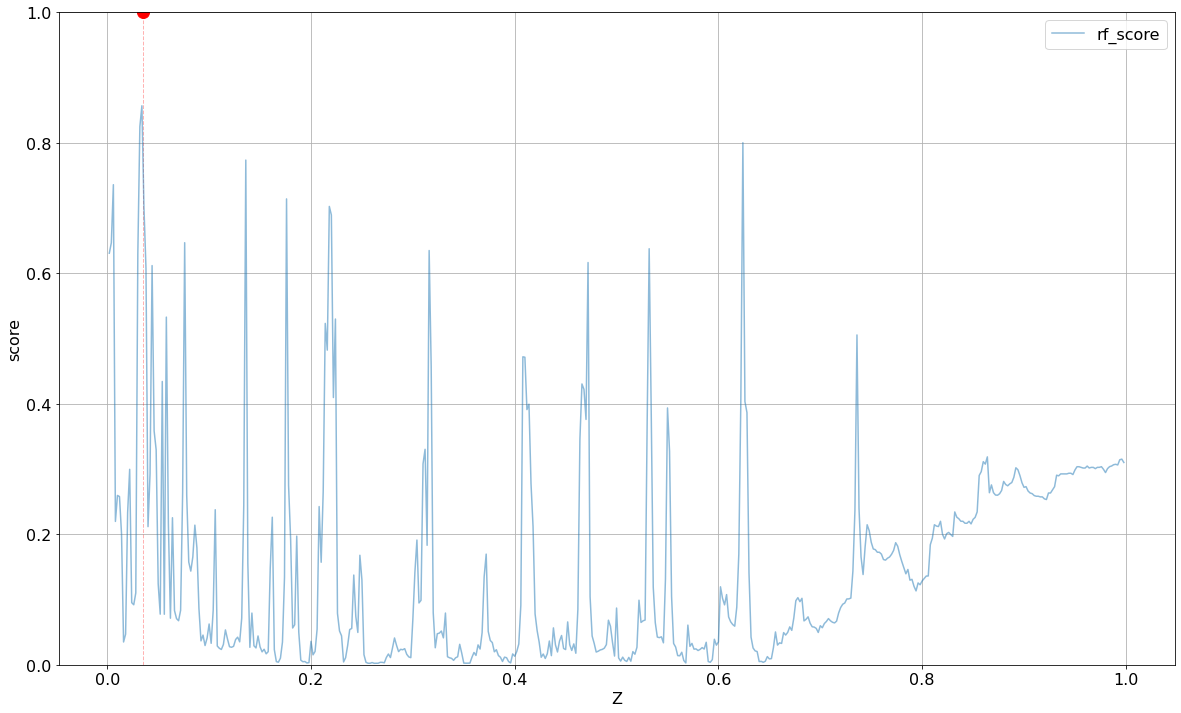

In [42]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 12))
plt.ylim(0, 1)
plt.grid()

ID = 0

plt.plot(
    test_clusters_ext[test_clusters_ext['ID'] == ID]['Z'][:],
    test_clusters_ext[test_clusters_ext['ID'] == ID]['rf_score'][:],
    alpha=0.5,
    label='rf_score'
)

plt.plot(
    test_clusters_ext[test_clusters_ext['ID'] == ID]['Z_true'].iloc[0], 
    1, 'ro', markersize=12
)
plt.vlines(
    test_clusters_ext[test_clusters_ext['ID'] == ID]['Z_true'].iloc[0],
    0, 1, colors='r', linestyles='--', linewidth=1, alpha=0.3
)

plt.xlabel('Z')
plt.ylabel('score')
plt.legend()

In [43]:
class CNNDataset(Dataset):
    def __init__(self, clusters_ext):
        self.clusters_ext = clusters_ext
        self.ids = sorted(clusters_ext['ID'].unique())
        self.feas = [
#             'logreg_score', 
#             'boosting_score', 
            'rf_score'
        ]
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id_ = self.ids[idx]
        
        out = []
        for f in self.feas:
            out.append(self.clusters_ext[self.clusters_ext['ID'] == id_][f])
        
        X = np.array(out)
        Y = self.clusters_ext[self.clusters_ext['ID'] == id_]['type'].iloc[0]
        
        return X, Y

In [44]:
train_dataset = CNNDataset(train_clusters_ext)
test_dataset = CNNDataset(test_clusters_ext)

In [45]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [46]:
class CNN(nn.Module):
    def __init__(self, n_channels):
        super(CNN, self).__init__()
        self.n_channels = n_channels

        self.features = nn.Sequential(
            nn.Conv1d(
                in_channels=self.n_channels, out_channels=1,
                kernel_size=3, stride=1
            ),
            nn.ReLU(),
            nn.MaxPool1d(2),
#             nn.Conv1d(
#                 in_channels=3, out_channels=3,
#                 kernel_size=3, stride=1
#             ),
#             nn.ReLU(),
#             nn.MaxPool1d(2)
        )
        
        self.clf = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(248, 2),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        out = self.clf(x)

        return out

In [47]:
def train(train_dataloader, test_dataloader, net, optimizer, criterion, n_epochs):
    for epoch in range(n_epochs):
        start_time = time.time()
        train_losses = []
        for X, Y in train_dataloader:
            X = X.float()
            preds = net(X)
            Y_ = torch.zeros((Y.size(0), 2))
            Y_[:, Y] = 1
            loss = criterion(preds, Y_)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        test_preds, test_Y = [], []
        for X, Y in test_dataloader:
            X = X.float()
            preds = net(X)
            preds = preds.argmax(axis=1)
            test_preds.append(preds.reshape(-1))
            test_Y.append(Y)
        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_Y = torch.cat(test_Y).cpu().detach().numpy()
        test_rocauc = roc_auc_score(test_Y, test_preds)
        end_time = time.time()
        print(
            "Epoch {}, training loss {:.4f}, test ROCAUC {:.4f}, time {:.2f}".format(
                epoch, np.mean(train_losses), test_rocauc,
                end_time - start_time
            )
        )

In [48]:
# cnn = CNN(1)
# w = torch.Tensor([0.15, 0.85])
# criterion = torch.nn.BCELoss(w)
# optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)
# train(
#     train_dataloader, test_dataloader,
#     cnn, optimizer, criterion, 30
# )

In [362]:
CX = clusters['CX'].values.reshape((-1, 1))
CY = clusters['CY'].values.reshape((-1, 1))
CZ = clusters['CZ'].values.reshape((-1, 1))

c = np.concatenate((CX, CY, CZ), axis=1)
DPS = disperse.Disperse3D.read(f'ACT_01_dumps/0.2/')
CX = np.array(DPS.galaxies['CX'].values).reshape(-1, 1)
CY = np.array(DPS.galaxies['CY'].values).reshape(-1, 1)
CZ = np.array(DPS.galaxies['CZ'].values).reshape(-1, 1)
points = np.concatenate((CX, CY, CZ), axis=1)
kd_tree = KDTree(points, leaf_size=2)

res = kd_tree.query_radius(c, 2, return_distance=False)

In [50]:
no_gal_mask = []

count = 0
for r in res:
    if len(r) > 0:
        no_gal_mask.append(False)
        count += 1
    else:
        no_gal_mask.append(True)

no_gal_mask = np.array(no_gal_mask)

In [51]:
score = np.zeros(clusters.shape[0])
z_pred = np.zeros(clusters.shape[0])
for id_ in tqdm(train_clusters['ID']):
    i = train_clusters_ext[train_clusters_ext['ID'] == id_]['rf_score'].argmax()
    score[id_] = train_clusters_ext[train_clusters_ext['ID'] == id_]['rf_score'].values[i]
    z_pred[id_] = train_clusters_ext[train_clusters_ext['ID'] == id_]['Z'].values[i]
    
for id_ in tqdm(test_clusters['ID']):
    i = test_clusters_ext[test_clusters_ext['ID'] == id_]['rf_score'].argmax()
    score[id_] = test_clusters_ext[test_clusters_ext['ID'] == id_]['rf_score'].values[i]
    z_pred[id_] = test_clusters_ext[test_clusters_ext['ID'] == id_]['Z'].values[i]

100%|██████████| 352/352 [00:00<00:00, 724.31it/s]


In [146]:
y = clusters['type'].values
z_true = clusters['Z'].values

In [360]:
true_mask = (y == 1)
m_mask = clusters['M'].values > 6
z_mask = clusters['Z'].values < 1.1
(m_mask * z_mask * no_gal_mask).sum()

0

In [363]:
score[no_gal_mask][20]

0.974

In [355]:
true_score = score[true_mask * m_mask * z_mask]
true_type = np.array([1] * true_score.shape[0])

In [356]:
false_score = score[~true_mask * z_mask][::]
false_type = np.array([0] * false_score.shape[0])
(~true_mask * z_mask).sum()

3000

In [357]:
score_01 = np.concatenate((true_score, false_score))
type_01 = np.concatenate((true_type, false_type))

In [358]:
roc_auc_score(type_01, score_01)

0.6903333333333334

In [359]:
score_01

array([0.9675    , 0.998     , 0.972     , ..., 0.98996364, 0.986     ,
       0.952     ])

In [168]:
type_01

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [159]:
t = dists[:true_clusters.shape[0]][no_gal_mask[:true_clusters.shape[0]]]

In [161]:
t.shape

(48, 70)

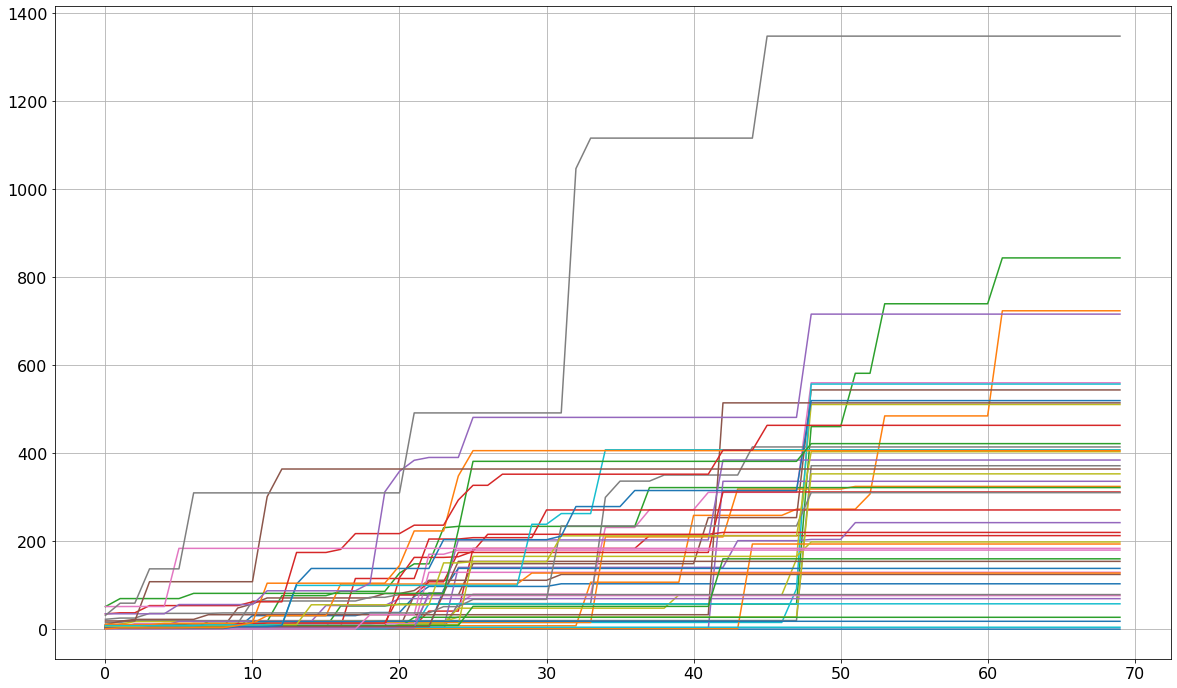

In [205]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 12))
plt.grid()

for i in range(t.shape[0]):
    plt.plot(t[i])

In [189]:
t[5]

array([  1.67601942,   1.67601942,   1.67601942,   1.67601942,
         1.67601942,   1.67601942,   1.67601942,   1.79526025,
         1.79526025,   1.79526025,   1.79526025,   1.79526025,
         1.79526025,   1.79526025,   1.79526025,   1.79526025,
         1.79526025,   1.79526025,   1.79526025,   1.79526025,
         1.79526025,  77.44277812,  77.44277812,  77.44277812,
        77.44277812, 148.89061656, 148.89061656, 148.89061656,
       148.89061656, 148.89061656, 148.89061656, 148.89061656,
       148.89061656, 148.89061656, 148.89061656, 148.89061656,
       148.89061656, 148.89061656, 148.89061656, 148.89061656,
       148.89061656, 253.51129101, 253.51129101, 253.51129101,
       253.51129101, 253.51129101, 253.51129101, 253.51129101,
       543.53907666, 543.53907666, 543.53907666, 543.53907666,
       543.53907666, 543.53907666, 543.53907666, 543.53907666,
       543.53907666, 543.53907666, 543.53907666, 543.53907666,
       543.53907666, 543.53907666, 543.53907666, 543.53

In [198]:
t[14]

array([  0.39679965,   0.80579656,   0.80579656,   0.80579656,
         0.80579656,   0.80579656,   0.80579656,   0.80579656,
         0.80579656,   0.80579656,   0.80579656,   0.80579656,
         0.80579656,   0.80579656,   0.80579656,   0.80579656,
         0.80579656,   0.80579656,   0.80579656,   0.80579656,
         0.80579656,   0.80579656,   0.80579656,   0.80579656,
         0.80579656,   0.80579656,   0.80579656,   0.80579656,
         0.80579656,   0.80579656,   0.80579656,   0.80579656,
         0.80579656,   0.80579656,   0.80579656,   0.80579656,
         0.80579656,   0.80579656,   0.80579656,   0.80579656,
         0.80579656,   0.80579656, 336.02389724, 336.02389724,
       336.02389724, 336.02389724, 336.02389724, 336.02389724,
       336.02389724, 336.02389724, 336.02389724, 336.02389724,
       336.02389724, 336.02389724, 336.02389724, 336.02389724,
       336.02389724, 336.02389724, 336.02389724, 336.02389724,
       336.02389724, 336.02389724, 336.02389724, 336.02

In [204]:
t[20]

array([0.82538409, 0.82538409, 0.82538409, 0.82538409, 0.82538409,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ,
       0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 , 0.2316673 ])

In [237]:
true_clusters.loc[no_gal_mask[:519]].iloc[20]

RA       186.919629
DEC        7.742491
Z          0.478586
M          1.844139
R          0.000000
type       1.000000
CX     -1842.881179
CY      -223.653764
CZ       252.397563
ID       286.000000
Name: 286, dtype: float64

In [267]:
DPS_01 = disperse.Disperse3D.read(f'ACT_01_dumps/14.0/')

In [268]:
MIN_SEG_LEN = 1  # Mpc

points = []
next_point = []
fil_num = []
count = 0
for i, fil in enumerate(DPS_01.fils):
    sp = fil['sample_points']
    for j in range(len(sp) - 1):
        points.append([sp[j]['CX'], sp[j]['CY'], sp[j]['CZ']])
        fil_num.append(i)
        count += 1
        next_point.append(count)
        d = disperse.dist(
            sp[j]['CX'], sp[j]['CY'], sp[j]['CZ'],
            sp[j + 1]['CX'], sp[j + 1]['CY'], sp[j + 1]['CZ']
        )
        if d > MIN_SEG_LEN:
            n = int(d // MIN_SEG_LEN + 1)
            d_x = sp[j + 1]['CX'] - sp[j]['CX']
            d_y = sp[j + 1]['CY'] - sp[j]['CY']
            d_z = sp[j + 1]['CZ'] - sp[j]['CZ']
            for k in range(1, n):
                points.append([sp[j]['CX'] + k * d_x / n, sp[j]['CY'] + k * d_y / n, sp[j]['CZ'] + k * d_z / n])
                fil_num.append(i)
                count += 1
                next_point.append(count)
    points.append([sp[-1]['CX'], sp[-1]['CY'], sp[-1]['CZ']])
    fil_num.append(i)
    count += 1
    next_point.append(None)

kd_tree = KDTree(points, leaf_size=2)

In [269]:
kd_tree.query_radius([[-1842.881179, -223.653764, 252.397563]], r=0.85)

array([array([11298, 11299])], dtype=object)

In [272]:
next_point[11299]

11300

In [ ]:
disperse.dist(
    -1842.781157838287, -223.88242318293828, 253.1846328944487,
    -1842.881179, -223.653764, 252.397563
)